# libraries

In [1]:
#libraries and dirrectory 
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import curve_fit
import patientFunctions as ptfn
import seaborn as sns
import matplotlib.pyplot as plt
import re
import matplotlib.patches as mpatches


# directories

In [2]:
#location of original data
starting_directory = os.getcwd()


# machine_directory = 'C:/Users/mcremer' #the C and path to the project folder
machine_directory = 'C:/Users/maega' #when working from home machine
storage_directory = 'UFL Dropbox/Maegan Cremer/research-share/Maegan/Projects' #Local, HPG, or dropbox
project_directory = 'Cardiac-Amyloidosis-Multiple-Myeloma' #project folder
project_lv2_directory = '012 Processed Data/data-2024-06-05' #deeper part of project folder

path = os.path.join(machine_directory, storage_directory, 
                    project_directory, project_lv2_directory)

new_dirrectory = path

os.chdir(new_dirrectory)

In [3]:
#updates to directory management
# machine_directory = 'C:/Users/mcremer' #the C and path to the project folder
machine_directory = 'C:/Users/maega' #when working from home machine
storage_directory = 'UFL Dropbox/Maegan Cremer/research-share/Maegan/Projects' #Local, HPG, or dropbox
project_directory = 'Cardiac-Amyloidosis-Multiple-Myeloma' #project folder
project_lv2_directory = '017_Mistic_noNotes_t-60' #deeper part of project folder

path = os.path.join(machine_directory, storage_directory, 
                    project_directory, project_lv2_directory)

# parent_dir = path
outputDir = path

In [4]:
folderNameHeader = "StatsVisuals_"
folderNameCommon = ""
folderNameSuffix = "_20250516"

# fileNameHeader_1 = "DF_SelectedFeats_"
# # fileNameHeader_2 = "ALUnknownPts"
# # fileNameCommon = "_Features"
# fileNameSuffix = "_20250416"

folder_data_out = ptfn.makeFolderPathForData(parent_dir=outputDir, folderName_header=folderNameHeader, 
                                        folderName_common=folderNameCommon, folderName_suffix=folderNameSuffix)


folderNameOut = folder_data_out

# import data

## patient info

In [5]:
#importing patient data as dictionaries of dataframes

#build a dictionary of patients and their values 
ptFiles = ptfn.GetListofPTfiles(new_dirrectory, '.xlsx', 'data')

ptDict = {}

#loop through the listOfPatients 
for file in ptFiles: 
    pt = ptfn.patient(new_dirrectory, file, 4)
    ptDict[pt.ptID] = pt

In [6]:
EchoTimeColumn ='time from diagnosis to first echo (months)'
MRITimeColumn = 'time from dagnosis to MRI (months)'
echoDates = {}
for pt in ptDict.keys():
    ptEchoData = ptDict[pt].echoData
    patientEchoDate = ptEchoData[EchoTimeColumn]
    if 'none' not in list(patientEchoDate):
        echoDates[pt] = patientEchoDate

#test to see if this still runs and if the data is correct

In [7]:
#list of patients by amyloid status 

listPositive = []
listNegative = []
listOther = []

#T-01 was added to the list of patients to remove for having no note data
list_pts_remove = ["K-01", "G-01", "J-01", "L-02"]
#remove list_pts_remove from ptDict
for pt in list_pts_remove:
    if pt in ptDict:
        del ptDict[pt]

#get list of positive patients 
for pt in ptDict:
    ptALStatus = ptDict[pt].amyloid_status
    if ptALStatus == 'yes':
        listPositive.append(pt)
    elif ptALStatus == 'no':
        listNegative.append(pt)
    else:
        listOther.append(pt)


In [8]:

listKnown = listPositive + listNegative

In [9]:
#changing dictionary of patients to only those with known status
#this fixes issues throughout the code where ptDict.keys() was used instead of listKnown
for pt in listOther:
    ptDict.pop(pt)

## trim time to no later than 60 days before diagnosis

In [ ]:
labsTimeColumn = 'RelTime(Days)'
noteTimeColumn = 'time from diagnosis to note (months)'

for pt in ptDict.keys(): 
    #pull each data input type (labs and notes) and filter for only positive time
    ptLabs = ptDict[pt].labsData
    ptDict[pt].labsData = ptLabs.loc[ptLabs[labsTimeColumn] >= -60].reset_index()

    #repeat for the note column 
    ptNotes = ptDict[pt].MDnotes
    ptDict[pt].MDnotes = ptNotes.loc[ptNotes[noteTimeColumn]>= 0].reset_index()


## list of labs

In [11]:
os.chdir(path) #chaning directory to the location of our sheets

In [12]:
os.getcwd()

'C:\\Users\\maega\\UFL Dropbox\\Maegan Cremer\\research-share\\Maegan\\Projects\\Cardiac-Amyloidosis-Multiple-Myeloma\\017_Mistic_noNotes_t-60'

In [13]:
#to get only the lab names used as stems of features
labsFiltered = pd.read_excel("DFsForSVM_noNotes_t-60__20250506_v1\SelectedFeatures_labs__20250506_v1.xlsx")
labsFiltered = list(labsFiltered[0])

## features dataframes

In [14]:
# full dataframe for the DescFits model
DescFitsFullFeatureList = pd.read_excel("DFsForSVM_noNotes_t-60__20250506_v1\DF_SVM_noNotes_t-60_DescFits_sk__20250506_v1.xlsx")
DescFitsFullFeatureList.index = DescFitsFullFeatureList["DeID"]

In [15]:
#full dataframe for the EchoAdj model 
EchoAdjFullFeatureList = pd.read_excel("DFsForSVM_noNotes_t-60__20250506_v1\DF_SVM_noNotes_t-60_EchoAdj__20250506_v1.xlsx")
EchoAdjFullFeatureList.index = EchoAdjFullFeatureList["DeID"]

In [16]:
#labs adjacent to diagnositic imaging
#use the EchoAdj full feature list, but remove the dummy variables 
ImagingAdjValues = EchoAdjFullFeatureList.replace(-1, np.nan)

# temporary variables

In [17]:
featureRed = 0.25 #feature reduction value of interest
modelNames = ['EchoAdj', 'DescOnly', 'ParamsOnly', 'DescFits']

## features selected for each model 

In [18]:
selectedFeatures_allmodels_allfeatRed = pd.read_excel("SVM_model_comparison_noNotes_t-60.xlsx", sheet_name = "best feats", header = [0,1]) #.drop([0], axis = 0)

In [19]:
selectedFeatures_allmodels_allfeatRed

,model,EchoAdj no notes,DescOnly no notes,ParamsOnly no notes,DescFits no notes
,feature reduction,0.25,0.25,0.25,0.25
0,NaN,age,Beta-2-Microglobulin_25%,RadiationTx_True,age
1,NaN,survival(mo),Creatinine_min,Calcium_linear_r2,BUN_mean
2,NaN,Albumin,NaN,Chloride_linear_intercept,BUN_min
3,NaN,BUN,NaN,Immature Gran Auto_linear_mse,BUN_25%
4,NaN,Beta-2-Microglobulin,NaN,Monocyte_linear_r2,BUN_50%
5,NaN,Chloride,NaN,Beta-2-Microglobulin_exp_intercept,Chloride_mean
6,NaN,Creatinine,NaN,Chloride_exp_intercept,Chloride_25%
7,NaN,LDH,NaN,Chloride_exp_r2,Chloride_50%
8,NaN,Serum Electrophoresis Alpha 2,NaN,Serum Electrophoresis Alpha 1_exp_intercept,Chloride_max


In [20]:
featureRed = 0.25 #feature reduction value of interest

#pull selected features for the models with the given feature reduction
selectedFeats_025_allmodels = selectedFeatures_allmodels_allfeatRed.xs(featureRed, axis = 1, level = 1)

#list of models 
modelNames = list(selectedFeats_025_allmodels.columns)

In [21]:
selectedFeaturesFolder = "DF_SelectedFeats_20250508"
selectedFeaturesFiles = os.listdir(selectedFeaturesFolder)

In [22]:
dict_selectedFeatures_dfs = {}

for fileName in selectedFeaturesFiles:
    for name in modelNames: 
        if name in fileName and str(featureRed).replace(".", "") in fileName:
            print(name, " with feature reduction ", str(featureRed), " is in ", fileName)
            data = pd.read_excel(os.path.join(selectedFeaturesFolder, fileName))
            data.index = data["DeID"]
            dict_selectedFeatures_dfs[name] = data.drop("DeID", axis = 1)

## stats dataframes

In [23]:
statsFolder = "MannWhitneyFeaturesStats"
statsFiles = os.listdir(statsFolder)

In [24]:
dict_stats_allfeats_dfs = {}
dict_stats_selectedfeats_dfs = {}

df_stats_adjLabsOnly = [] #for the stats of ONLY imaging adjacent labs

for fileName in statsFiles:
    for name in modelNames: 
        if name in fileName and "selected" not in fileName:
            print(name, " is in ", fileName)
            data = pd.read_csv(os.path.join(statsFolder, fileName))
            data = data.rename(columns={"Unnamed: 0": "feature"})
            data.index = data["feature"]
            dict_stats_allfeats_dfs[name] = data
        if name in fileName and "selected" in fileName: 
            print(name, " is in ", fileName)
            data = pd.read_csv(os.path.join(statsFolder, fileName))
            data = data.rename(columns={"Unnamed: 0": "feature"})
            data.index = data["feature"]
            dict_stats_selectedfeats_dfs[name] = data
        if name not in fileName and "adjLabsOnly" in fileName: 
            print("Adjacent labs to date of imaging only: ", fileName)
            data =pd.read_csv(os.path.join(statsFolder, fileName))
            data = data.rename(columns={"Unnamed: 0": "feature"})
            data.index = data["feature"]
            df_stats_adjLabsOnly = data
            break


Adjacent labs to date of imaging only:  Multiple Mann-Whitney tests of adjLabsOnly.csv


In [25]:
dict_stats_allfeats_dfs.keys()

dict_keys([])

# visualizations

## swarm plot Echo

In [26]:
from sklearn.preprocessing import StandardScaler

#collect the echoAdj data and apply the standard scalar
ImagingAdj_forPlot = ImagingAdjValues[labsFiltered] #filtering for only selected labs

#fitting and applying the standard scaler to the data 
EchoAdjValues_StandardScalar = StandardScaler().fit(ImagingAdj_forPlot).transform(ImagingAdj_forPlot)

#setting the index and column names so that the data is searchable
EchoAdj_StandardScalar_df = pd.DataFrame(EchoAdjValues_StandardScalar, index=EchoAdjFullFeatureList.index, columns=labsFiltered)


c:\Users\maega\anaconda3\envs\BEAT-Labs_2024-08-02\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 28.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\maega\anaconda3\envs\BEAT-Labs_2024-08-02\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 35.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\maega\anaconda3\envs\BEAT-Labs_2024-08-02\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\maega\anaconda3\envs\BEAT-Labs_2024-08-02\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 60.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 157.7222222222222, 'Standardized Values')

c:\Users\maega\anaconda3\envs\BEAT-Labs_2024-08-02\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 23.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


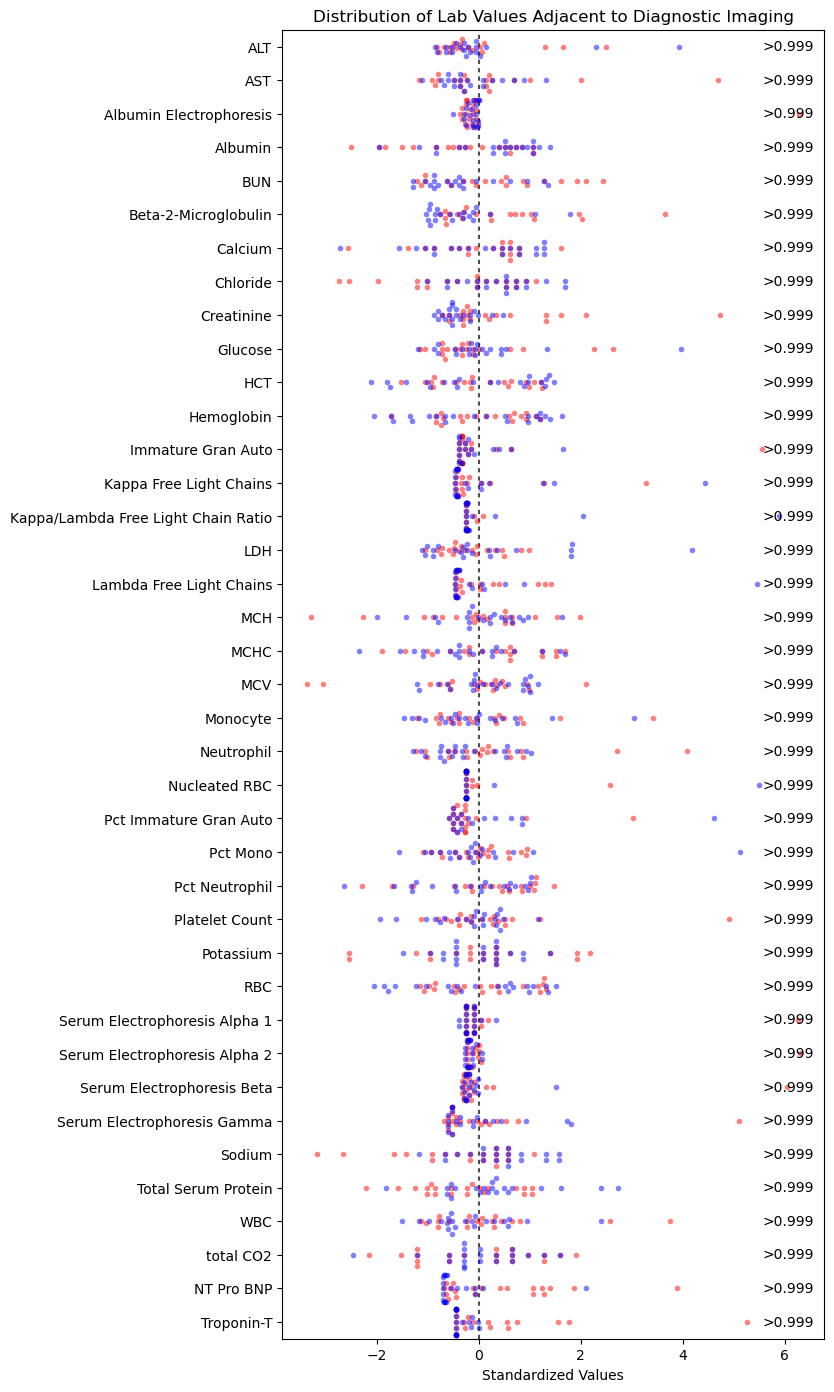

In [27]:
#swarm plots

#first collect the stats and values after standard scalar
data_afterScaler = EchoAdj_StandardScalar_df
stats_df = df_stats_adjLabsOnly

#ensure that the labs are in the same order 
stats_df = stats_df.reindex(data_afterScaler.T.index)

# Adding the swarm plot
fig, axs = plt.subplots(figsize=(7, 17))
sns.swarmplot(data_afterScaler.loc[listPositive], color='red', orient='h', size=4, alpha=0.5, ax=axs)
sns.swarmplot(data_afterScaler.loc[listNegative], color='blue', orient='h', size=4, alpha=0.5, ax=axs)

#adding central line for reference
axs.axvline(0, color=".3", dashes=(2, 2))

# Adding text descriptions for adjusted p-value
for i, feature in enumerate(stats_df.index.dropna()):
    pvalue = stats_df.loc[feature, "Adjusted P Value"]
    if not isinstance(pvalue, str):
        pvalue = round(pvalue, 3)
        #this rounds all numeric p values to 3 decimal places
    axs.text(0.98, i, f"{pvalue}", 
            va='center', ha='right', fontsize=10, color='black', transform=axs.get_yaxis_transform())
    
plt.title("Distribution of Lab Values Adjacent to Diagnostic Imaging")
axs.set_xlabel("Standardized Values")

## box plots of means of labs across the dataset

In [28]:
#collect the list of lab mean features from DescFits feature list
featureNames_means = [feature for feature in list(DescFitsFullFeatureList.columns) if "mean" in feature]


In [29]:
#filter the list again to only include lab values
labsNames_means_dict = {} #keys are labs, values are the lab_mean
for lab in labsFiltered: 
    for mean in featureNames_means:
        if lab in mean: 
            labsNames_means_dict[lab] = mean

In [30]:
#stats of means across patients for the filtered labs
#gather the means of labs per patient by CA status
df_labs_means_CApositive = DescFitsFullFeatureList.loc[listPositive][list(labsNames_means_dict.values())]
df_labs_means_CAnegative = DescFitsFullFeatureList.loc[listNegative][list(labsNames_means_dict.values())]

#descriptive stats
df_labs_means_CApositive_desc = df_labs_means_CApositive.describe().T.sort_values("mean")
df_labs_means_CAnegative_desc = df_labs_means_CAnegative.describe().T.sort_values("mean")

In [31]:
dict_plottingRanges = {"graph 10": [0, 0.5],
                       "graph 20": [0.6, 2],
                       "graph 30": [2, 10],
                       "graph 40": [11, 50],
                    #    "graph 50": [26, 50],
                       "graph 60": [51, 100],
                       "graph 70": [101, 400],
                       "graph 80" : [401, 1000],
                       "graph 90": [1000, 10000]}
dict_graph_column_groups = {}

for graph in dict_plottingRanges.keys():
    a, b = dict_plottingRanges[graph][0], dict_plottingRanges[graph][1]
    dict_graph_column_groups[graph]= df_labs_means_CAnegative_desc.index[(df_labs_means_CAnegative_desc['mean'] >a) & (df_labs_means_CAnegative_desc['mean'] <b)]
            
    

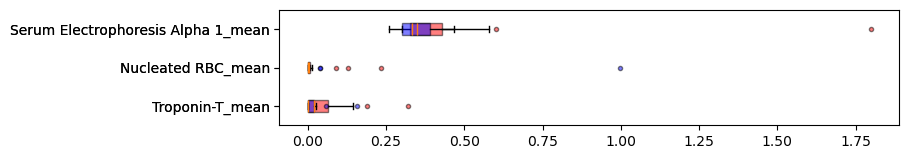

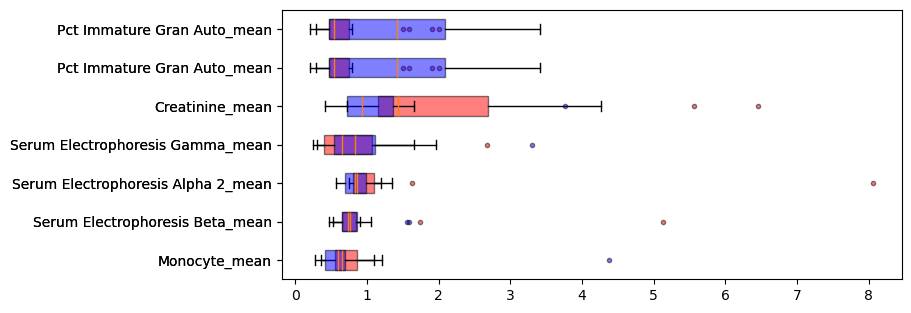

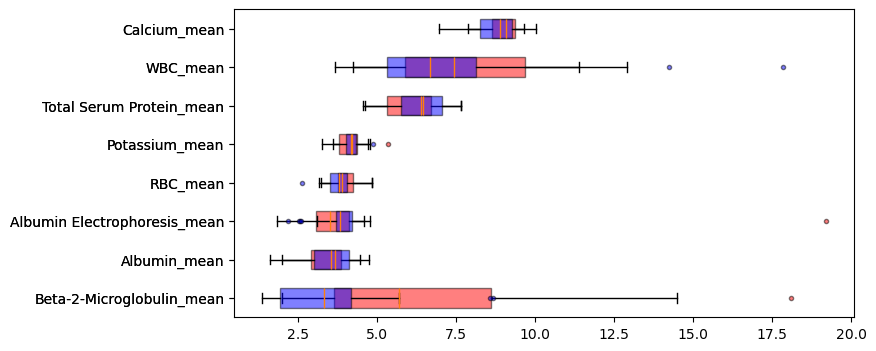

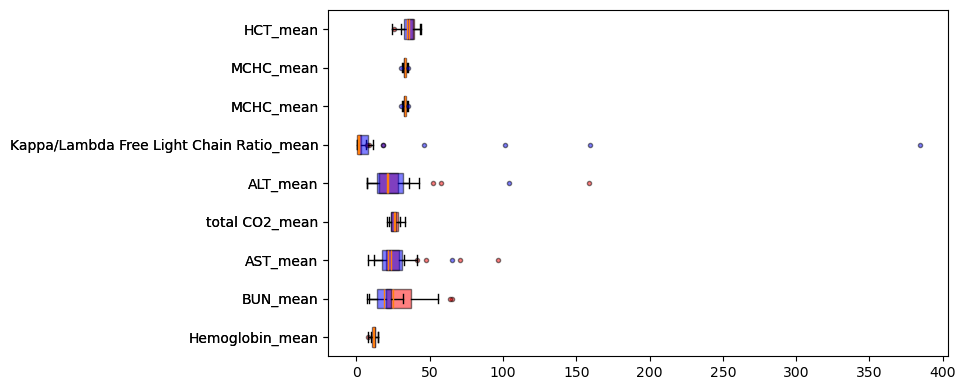

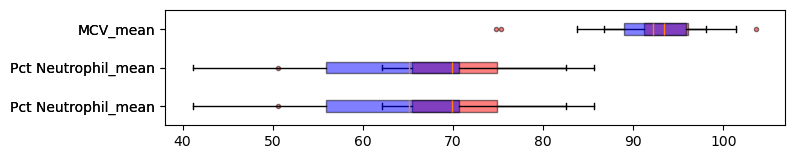

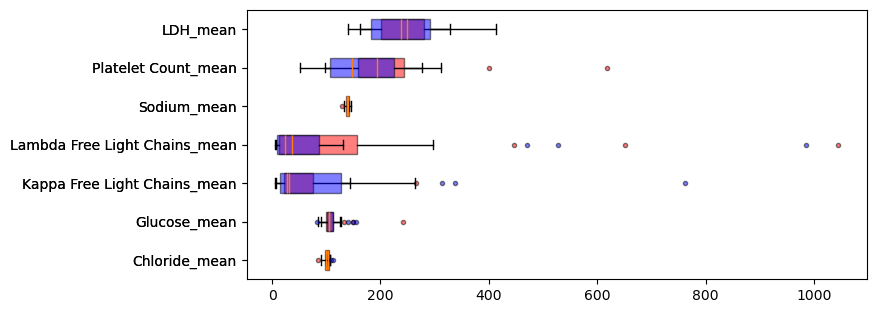

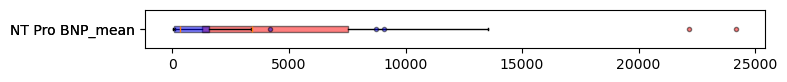

In [32]:
#plotting the distribution of means by CA status
figHeight = 0.5
for graph in dict_graph_column_groups.keys():
    #then plot the different pieces of data 
    if len(dict_graph_column_groups[graph]) >0: 
        fig, axs = plt.subplots(figsize = (8, len(dict_graph_column_groups[graph])*figHeight))
        plt.boxplot(DescFitsFullFeatureList.loc[listPositive][dict_graph_column_groups[graph]].dropna(),
                    vert= False, labels=dict_graph_column_groups[graph], patch_artist=True,
                    boxprops={"facecolor":"red", "alpha":0.5},
                    flierprops = {"marker" : '.', "markersize" : 6, "markerfacecolor" :'red', "alpha": 0.5})
        plt.boxplot(DescFitsFullFeatureList.loc[listNegative][dict_graph_column_groups[graph]].dropna(),
                    vert= False, labels=dict_graph_column_groups[graph], patch_artist=True,
                    boxprops={"facecolor":"blue", "alpha":0.5},
                    flierprops = {"marker" : '.', "markersize" : 6, "markerfacecolor" :'blue', "alpha": 0.5})
    

## small multiples plots

# Cardiac Imaging visuals

In [127]:
#for each patient, collect and plot the following labs 

echo_measures= ["1st_EF(avg%)", "1stGLS", '1st_outerLS', '1st_midLS', '1st_innerLS', 'MRI_EF(avg%)']

i = 0 
for pt in ptDict.keys():
    #pull patient data
    ptEchoData = ptDict[pt].echoData
    ptCAstatus = ptDict[pt].amyloid_status 
    #collect only the pieces you want
    dataEchoSlice = ptEchoData[echo_measures]
    #assign numeric for amyloid status 
    if ptCAstatus == 'yes': 
        ptCAstatus_numeric = 1
    elif ptCAstatus == 'no': 
        ptCAstatus_numeric = 0
    #add the amyloidstatus to the slice of data
    dataEchoSlice['CA_status_yes'] = ptCAstatus_numeric
    #add to a dataframe for plotting 
    df_tempEcho = dataEchoSlice
    df_tempEcho.index = [pt] #adding patient id in the index 

    #get the EF for the patient
    if df_tempEcho.at[pt,'1st_EF(avg%)'] == 'none':
        ptEF = df_tempEcho['MRI_EF(avg%)']
    else:
        ptEF = df_tempEcho['1st_EF(avg%)']

    if i == 0: 
        df_EchoSlices = df_tempEcho
        df_ptEF = ptEF
    if i > 0: 
        df_EchoSlices = pd.concat([df_EchoSlices, df_tempEcho])
        df_ptEF = pd.concat([df_ptEF, ptEF])

    i = i+1
    #add to existing dataframe? 
df_EchoSlices.replace('none', np.nan, inplace=True)
df_EchoSlices.replace('x', np.nan, inplace=True)
df_EchoSlices.replace('unable', np.nan, inplace=True)


C:\Users\maega\AppData\Local\Temp\ipykernel_9488\393697641.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataEchoSlice['CA_status_yes'] = ptCAstatus_numeric
C:\Users\maega\AppData\Local\Temp\ipykernel_9488\393697641.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataEchoSlice['CA_status_yes'] = ptCAstatus_numeric
C:\Users\maega\AppData\Local\Temp\ipykernel_9488\393697641.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [151]:
df_EchoSlices

,1st_EF(avg%),1stGLS,1st_outerLS,1st_midLS,1st_innerLS,MRI_EF(avg%),CA_status_yes
A-02,64.0,NaN,NaN,NaN,NaN,normal,0
B-02,67.5,14.3,11.200000,9.500000,19.8,NaN,1
B-03,62.5,16.2,14.500000,17.250000,24.0,61,0
C-01,62.5,21.7,19.500000,18.800000,25.8,67,0
C-02,62.5,19.3,16.800000,14.700000,25.4,NaN,0
C-03,62.5,20.4,17.666667,17.833333,25.8,69,1
E-01,62.0,17.8,13.700000,16.700000,22.6,NaN,1
E-02,60.0,NaN,NaN,NaN,NaN,NaN,1
E-03,62.5,NaN,NaN,NaN,NaN,71,0
F-01,62.5,17.7,15.200000,14.000000,24.8,NaN,0


In [128]:

df_EchoSlices_2 = df_EchoSlices[["1st_EF(avg%)", "1stGLS", '1st_outerLS', '1st_midLS', '1st_innerLS']]
df_EchoSlices_2['1st_EF(avg%)'] = df_ptEF


C:\Users\maega\AppData\Local\Temp\ipykernel_9488\2185593982.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_EchoSlices_2['1st_EF(avg%)'] = df_ptEF


In [129]:
df_EchoSlices_2

,1st_EF(avg%),1stGLS,1st_outerLS,1st_midLS,1st_innerLS
A-02,64.0,NaN,NaN,NaN,NaN
B-02,67.5,14.3,11.200000,9.500000,19.8
B-03,62.5,16.2,14.500000,17.250000,24.0
C-01,62.5,21.7,19.500000,18.800000,25.8
C-02,62.5,19.3,16.800000,14.700000,25.4
C-03,62.5,20.4,17.666667,17.833333,25.8
E-01,62.0,17.8,13.700000,16.700000,22.6
E-02,60.0,NaN,NaN,NaN,NaN
E-03,62.5,NaN,NaN,NaN,NaN
F-01,62.5,17.7,15.200000,14.000000,24.8


In [130]:
df_EchoSlices_2.loc[listPositive]

,1st_EF(avg%),1stGLS,1st_outerLS,1st_midLS,1st_innerLS
B-02,67.5,14.3,11.200000,9.500000,19.8
C-03,62.5,20.4,17.666667,17.833333,25.8
E-01,62.0,17.8,13.700000,16.700000,22.6
E-02,60.0,NaN,NaN,NaN,NaN
F-03,60.0,NaN,NaN,NaN,NaN
G-02,50.0,13.6,10.700000,11.200000,17.6
I-01,62.5,17.9,15.200000,15.700000,21.8
I-03,57.5,15.9,14.000000,15.500000,18.2
J-02,47.5,15.0,12.000000,13.000000,19.2
K-02,62.5,17.4,13.000000,16.500000,21.4


<Axes: >

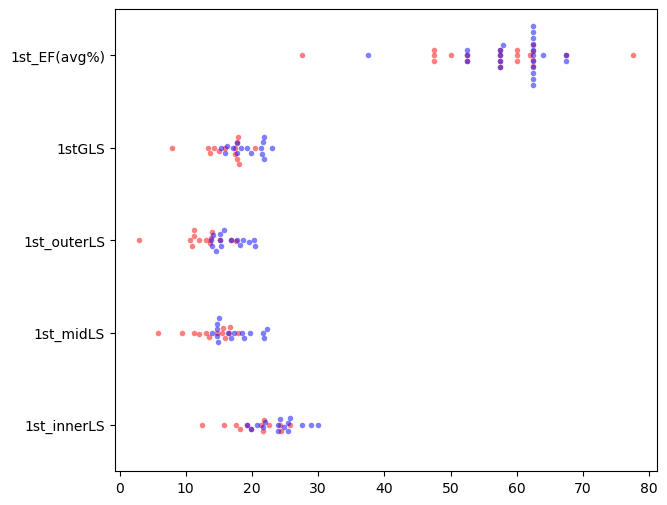

In [131]:
# Adding the swarm plot
fig, axs = plt.subplots(figsize=(7, 6))
sns.swarmplot(df_EchoSlices_2.loc[listPositive], color='red', orient='h', size=4, alpha=0.5, ax=axs)
sns.swarmplot(df_EchoSlices_2.loc[listNegative], color='blue', orient='h', size=4, alpha=0.5, ax=axs)


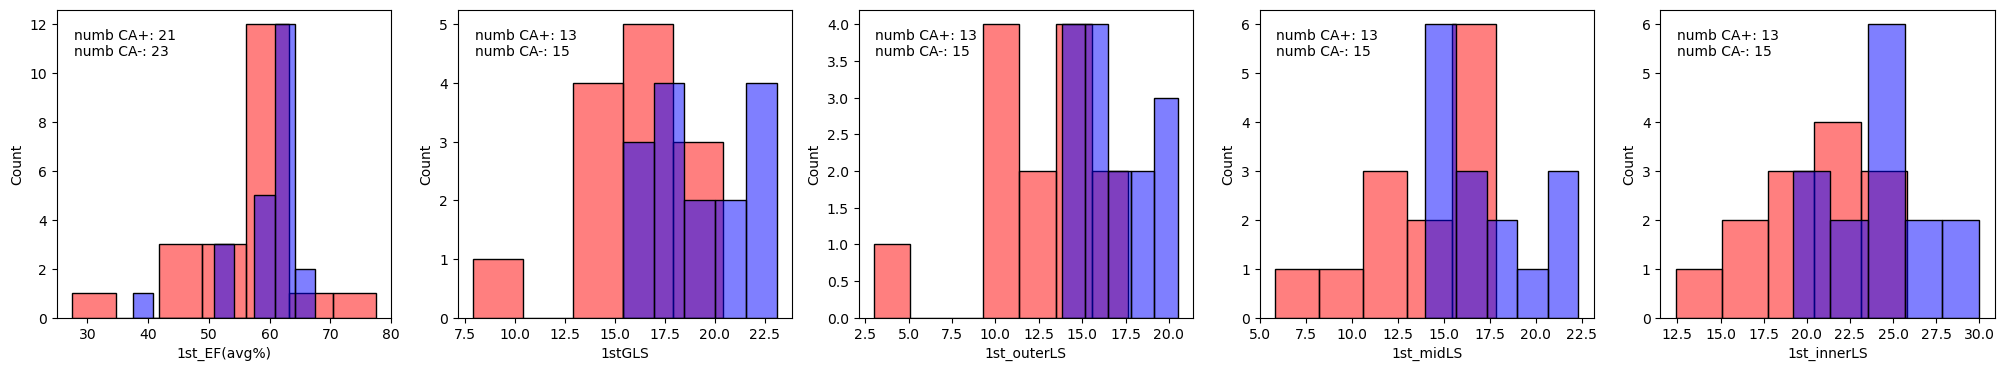

In [150]:
cols = 5
rows = 1
fig, axes = plt.subplots(rows, cols, figsize=(25, rows * 4))
axes = axes.flatten()  # Flatten the axes array for easy indexing
for i, stat in enumerate(["1st_EF(avg%)", "1stGLS", '1st_outerLS', '1st_midLS', '1st_innerLS']):
    ax = axes[i]
    #histograms
    sns.histplot(df_EchoSlices_2[stat][listPositive], color='red', alpha = 0.5, ax= ax)
    sns.histplot(df_EchoSlices_2[stat][listNegative], color='blue', alpha = 0.5, ax = ax)

    ax.annotate("numb CA+: " + str(len(df_EchoSlices_2[stat][listPositive].dropna())) + "\nnumb CA-: " + str(len(df_EchoSlices_2[stat][listNegative].dropna())), xy = (0.05,0.85),
                xycoords = 'axes fraction')
    # ax.text(1, 1,"numb CA-: " + str(len(df_EchoSlices_2[stat][listNegative].dropna())), bbox=dict(facecolor='blue', alpha=0.5))

In [137]:
len(df_EchoSlices_2[stat][listPositive].dropna())

13

# plots of patients note status

In [89]:
#dictionaries for conversion
dictECOGtoKPS = {0 : 95,
                 1 : 75, 
                 2 : 55, 
                 3 : 35, 
                 4 : 15, 
                 5 : 0}

dictKPStoECOG = {100: 0, 90: 0, 
                 80: 1, 70: 1, 
                 60: 2, 50: 2, 
                 40: 3 , 30: 3, 
                 20: 4, 10: 4, 0: 5 }

ptDictMDnotesScored = {}
#loop through the listOfPatients
for pt in ptDict.keys():
    #call each patient in the dictionary storing patient note information
    ptNotes = ptDict[pt].MDnotes

    if not isinstance(ptNotes, bool):

        #columns of interest
        listColumnNames = ['time from diagnosis to note (months)', 'ECOG Performance Status', 'Karnofsky Performance Status']
        ptNotesCorrected = ptNotes[listColumnNames]
        #convert the Karnofsky scores to integers
        ptNotesCorrected['Karnofsky Performance Status'] = ptNotesCorrected['Karnofsky Performance Status'].astype(str).str.extract('(\d+)').astype(float)

        #remove rows where the "ECOG Performance Status" is "OTHER"
        ptNotesCorrected = ptNotesCorrected[ptNotesCorrected['ECOG Performance Status'] != 'OTHER'] 
        #remove rows where the "Karnofsky Performance Status" is "OTHER"
        ptNotesCorrected = ptNotesCorrected[ptNotesCorrected['Karnofsky Performance Status'] != 'OTHER']

        # old methods, we will see if we still need this

        for i in list(ptNotesCorrected.index):
            #get the scores for that row
            ptTime = ptNotesCorrected.at[i, 'time from diagnosis to note (months)']
            ptECOG = ptNotesCorrected.at[i,'ECOG Performance Status']
            ptKPS = ptNotesCorrected.at[i, 'Karnofsky Performance Status']
        
            #if the value of ptECOG was "OTHER", then the row should be dropped.
            if ptECOG == "OTHER":
                # ptNotesCorrected.drop(index = i, inplace=True ) #drops the full row, would need to add time back if interested in clinical impression
                ptECOG = np.nan #replacement is dropped before descriptive stats are run
                ptKPS = np.nan #replacement is dropped before descriptive stats are run

            #infer ECOG from Karnofsky where you now have half points
            elif np.isnan(ptECOG) ==True and pd.isna(ptKPS) == False: 
                ptECOG = dictKPStoECOG[ptKPS]

            #infer Karnofsky from ECOG 
            elif pd.isna(ptKPS) == True and np.isnan(ptECOG) ==False: 
                ptKPS = dictECOGtoKPS[ptECOG]

            #save these values back to the dataframe
            if ptECOG != "OTHER":
                ptNotesCorrected.at[i,'ECOG Performance Status'] = ptECOG
                ptNotesCorrected.at[i, 'Karnofsky Performance Status'] = ptKPS
                                
        #saving the notes to the new dictionary
        ptDictMDnotesScored[pt] = ptNotesCorrected
    else:
        ptDictMDnotesScored[pt] = False


C:\Users\maega\AppData\Local\Temp\ipykernel_9488\1008972038.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ptNotesCorrected['Karnofsky Performance Status'] = ptNotesCorrected['Karnofsky Performance Status'].astype(str).str.extract('(\d+)').astype(float)
C:\Users\maega\AppData\Local\Temp\ipykernel_9488\1008972038.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ptNotesCorrected['Karnofsky Performance Status'] = ptNotesCorrected['Karnofsky Performance Status'].astype(str).str.extract('(\d+)').astype

In [104]:
ptNotesDescriptiveStats = {}
noteColumns = ["ECOG Performance Status", "Karnofsky Performance Status"]
for pt in  ptDict.keys():
    ptNotes = ptDictMDnotesScored[pt]  #[pt][noteColumns].astype(float)
    if not isinstance(ptNotes, bool):
        ptNotes =ptNotes[noteColumns].astype(float)
        #get the descriptive statistics for the notes
        ptNotesDescriptiveStats_calc = ptNotes.describe()
        ptNotesDescriptiveStats_calc['stats'] = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
        #when the count of data is 1, then use the value of the lab as the std
        for lab in noteColumns:
            if ptNotesDescriptiveStats_calc[lab]['count'] == 1:
                ptNotesDescriptiveStats_calc[lab]['std'] = ptNotesDescriptiveStats_calc[lab]['mean']
                ptNotesDescriptiveStats_calc[lab]['min'] = ptNotesDescriptiveStats_calc[lab]['mean']
                ptNotesDescriptiveStats_calc[lab]['25%'] = ptNotesDescriptiveStats_calc[lab]['mean']
                ptNotesDescriptiveStats_calc[lab]['50%'] = ptNotesDescriptiveStats_calc[lab]['mean']
                ptNotesDescriptiveStats_calc[lab]['75%'] = ptNotesDescriptiveStats_calc[lab]['mean']
                ptNotesDescriptiveStats_calc[lab]['max'] = ptNotesDescriptiveStats_calc[lab]['mean']
        #drop the count information
        ptNotesDescriptiveStats_calc.drop('count', axis=0, inplace=True)
        #melt to long format
        ptNotesDescriptiveStats_melt = ptNotesDescriptiveStats_calc[noteColumns].T.stack(future_stack=True)
        ptNotesDescriptiveStats[pt] = ptNotesDescriptiveStats_melt
    else:
        ptNotesDescriptiveStats[pt] = False

#make to dataframe
ptNotesDescriptiveStats_df = pd.DataFrame(ptNotesDescriptiveStats).T #each row is a patient
# flattens the multiindex columns into a single index with underscore as delimiter
ptNotesDescriptiveStats_df.columns = ['_'.join(col).strip() for col in ptNotesDescriptiveStats_df.columns.values]

C:\Users\maega\AppData\Local\Temp\ipykernel_9488\816328630.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ptNotesDescriptiveStats_calc[lab]['std'] = ptNotesDescriptiveStats_calc[lab]['mean']
C:\Users\maega\AppData\Local\Temp\ipykernel_

In [105]:
ptNotesDescriptiveStats_df.columns

Index(['ECOG Performance Status_mean', 'ECOG Performance Status_std',
       'ECOG Performance Status_min', 'ECOG Performance Status_25%',
       'ECOG Performance Status_50%', 'ECOG Performance Status_75%',
       'ECOG Performance Status_max', 'Karnofsky Performance Status_mean',
       'Karnofsky Performance Status_std', 'Karnofsky Performance Status_min',
       'Karnofsky Performance Status_25%', 'Karnofsky Performance Status_50%',
       'Karnofsky Performance Status_75%', 'Karnofsky Performance Status_max'],
      dtype='object')

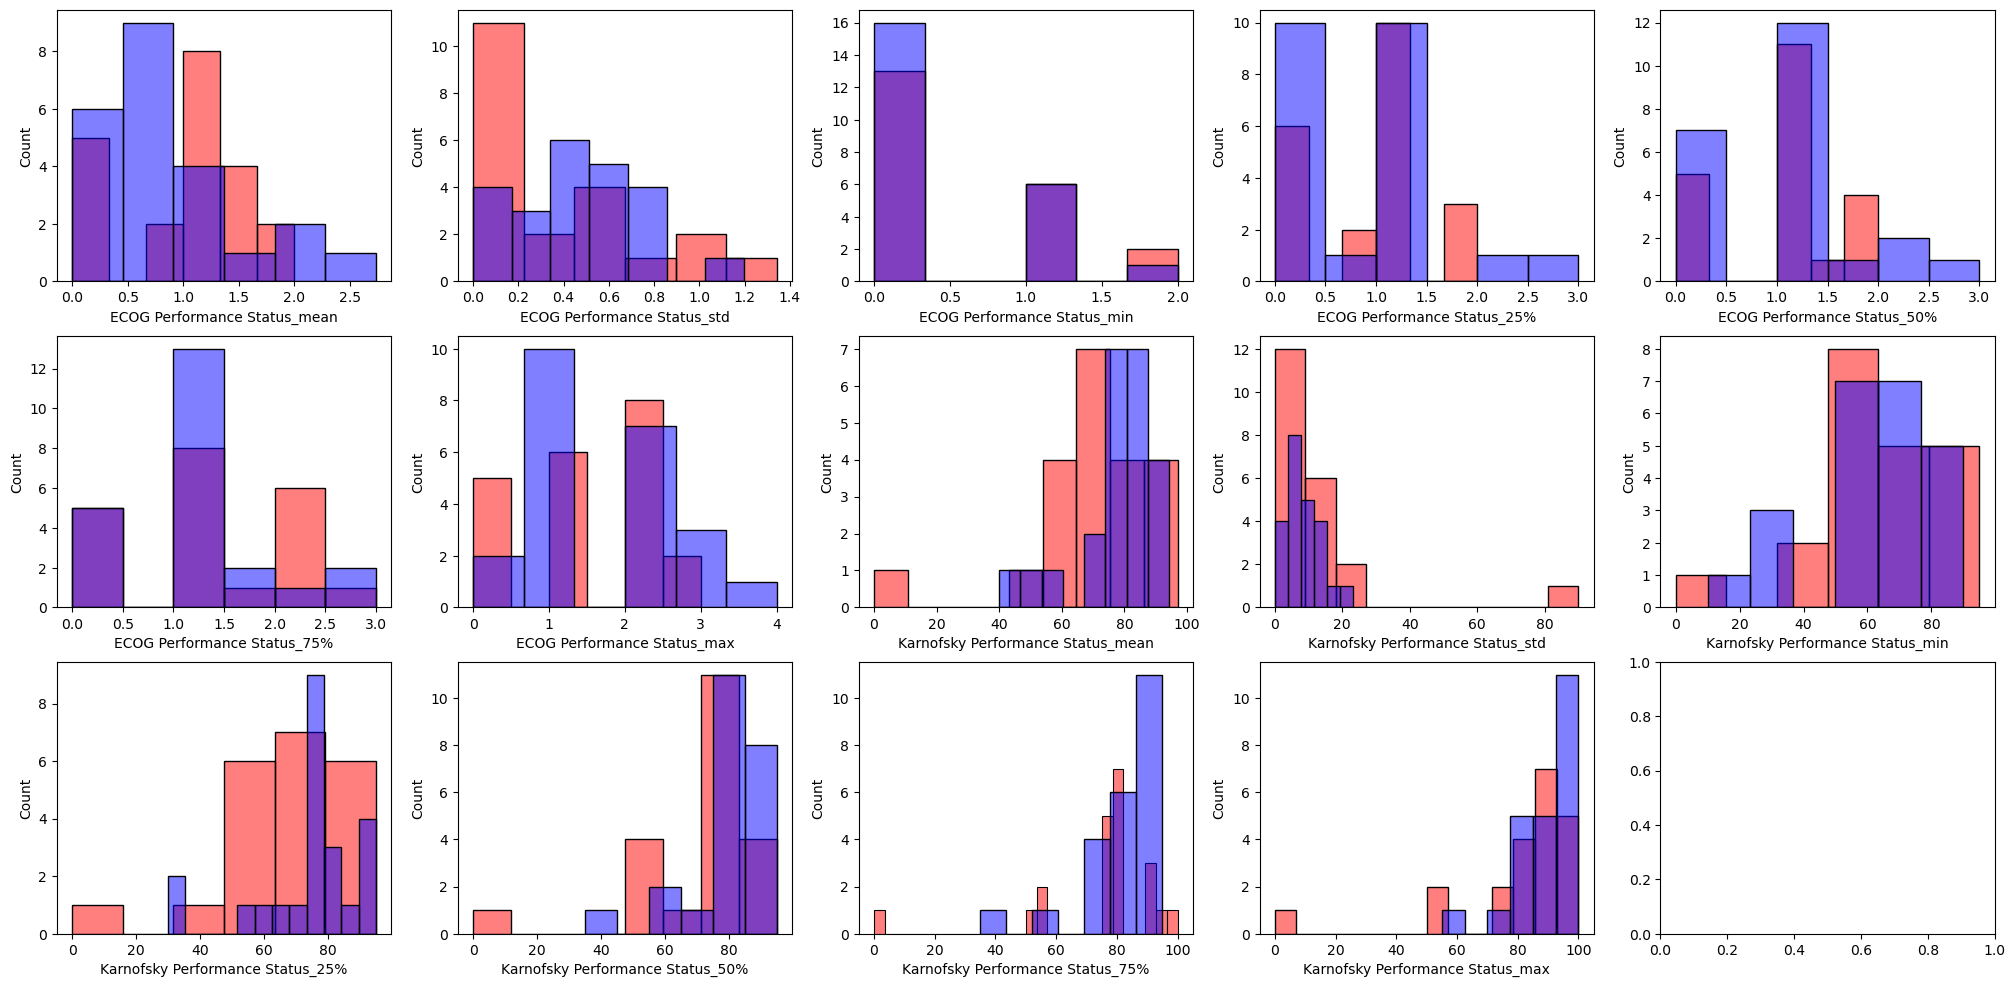

In [111]:
cols = 5
rows = 3
fig, axes = plt.subplots(rows, cols, figsize=(25, rows * 4))
axes = axes.flatten()  # Flatten the axes array for easy indexing
for i, stat in enumerate(ptNotesDescriptiveStats_df.columns):
    ax = axes[i]
    #histograms
    sns.histplot(ptNotesDescriptiveStats_df[stat][listPositive], color='red', alpha = 0.5, ax= ax)
    sns.histplot(ptNotesDescriptiveStats_df[stat][listNegative], color='blue', alpha = 0.5, ax = ax)

In [96]:
one_point_r2 = -1

In [97]:
#definitions of functions 

def linear_model_force(x, a):
    return a * x 

def prepDataForFit_v2(dataframe, time, dataColumn, transform = ["none"], shift = False):
    dataValues =dataframe[[time, dataColumn]] #collect the data

    #clean data for null or 0 data and remove any negative y values
    #negative y values are not physiologic
    if transform == ["none"]:
        dataValues = dataValues.dropna(axis = 'rows').loc[dataValues[dataColumn]>=0]
        x_values = dataValues[[time]] #time information
        y_values = dataValues[dataColumn] #collect the y values
        baseline = y_values.iloc[0]
        if shift == True:
            y_values_shift = y_values - baseline
            y_values = y_values_shift
    elif transform == ["ln"]:
        # ln tranform can't handle 0 values
        dataValues = dataValues.dropna(axis = 'rows').loc[dataValues[dataColumn]>=0]
        dataValues[dataColumn] = [value + 1 for value in dataValues[dataColumn]]
        x_values = dataValues[[time]] #time information
        y_values = dataValues[dataColumn] #collect the y values
        y_values = np.log(y_values)
        baseline = y_values.iloc[0]
        if shift == True:
            y_values_shift = y_values - baseline
            y_values = y_values_shift

    datalength = len(y_values)

    return x_values, y_values, datalength, baseline

#linear model fits using sk learn without adjustments for the baseline
def linear_model_fit_v2(x, y, datalength, baseline, forced = False):

    if datalength >1:
        if forced == False:
            #fit the data to a linear model scikitlearn linear regression
            # popt, pcov = curve_fit(linear_model_force, x, y)
            regression = LinearRegression().fit(x,y)
            #get the slope and intercept 
            coef = float(regression.coef_)
            intercept = regression.intercept_

            #test predictions
            y_prediction = regression.predict(x)

            #calculate the mean squared error
            mse = mean_squared_error(y, y_prediction)
            #calculate the coeficient of determination of the fit
            # r2 = r2_score(y, y_prediction)
            r2 = regression.score(x,y)

        if forced == True:
            x = x.squeeze()
            y = y.squeeze()
            #fit the data to a linear model using scipy curve_fit
            popt, pcov = curve_fit(linear_model_force, x, y)
            #get the slope and intercept from the popt array
            coef = popt[0]
            intercept = baseline

            #test predictions
            y_prediction = linear_model_force(x, coef)

            #calculate the mean squared error
            mse = mean_squared_error(y, y_prediction)
            #calculate the coeficient of determination of the fit
            r2 = r2_score(y, y_prediction)

    if datalength  ==1: 
        #if the data length is 1, then set slope to 0, set the intercept to the recorded value
        coef = 0
        intercept = baseline
        y_prediction = baseline #for plots
        mse = baseline
        r2 = one_point_r2

    return coef, intercept, mse, r2, y_prediction



C:\Users\maega\AppData\Local\Temp\ipykernel_9488\2888434675.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  coef = float(regression.coef_)
C:\Users\maega\AppData\Local\Temp\ipykernel_9488\2888434675.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  coef = float(regression.coef_)
C:\Users\maega\AppData\Local\Temp\ipykernel_9488\2888434675.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  coef = float(regression.coef_)
C:\Users\maega\AppData\Local\Temp\ipy

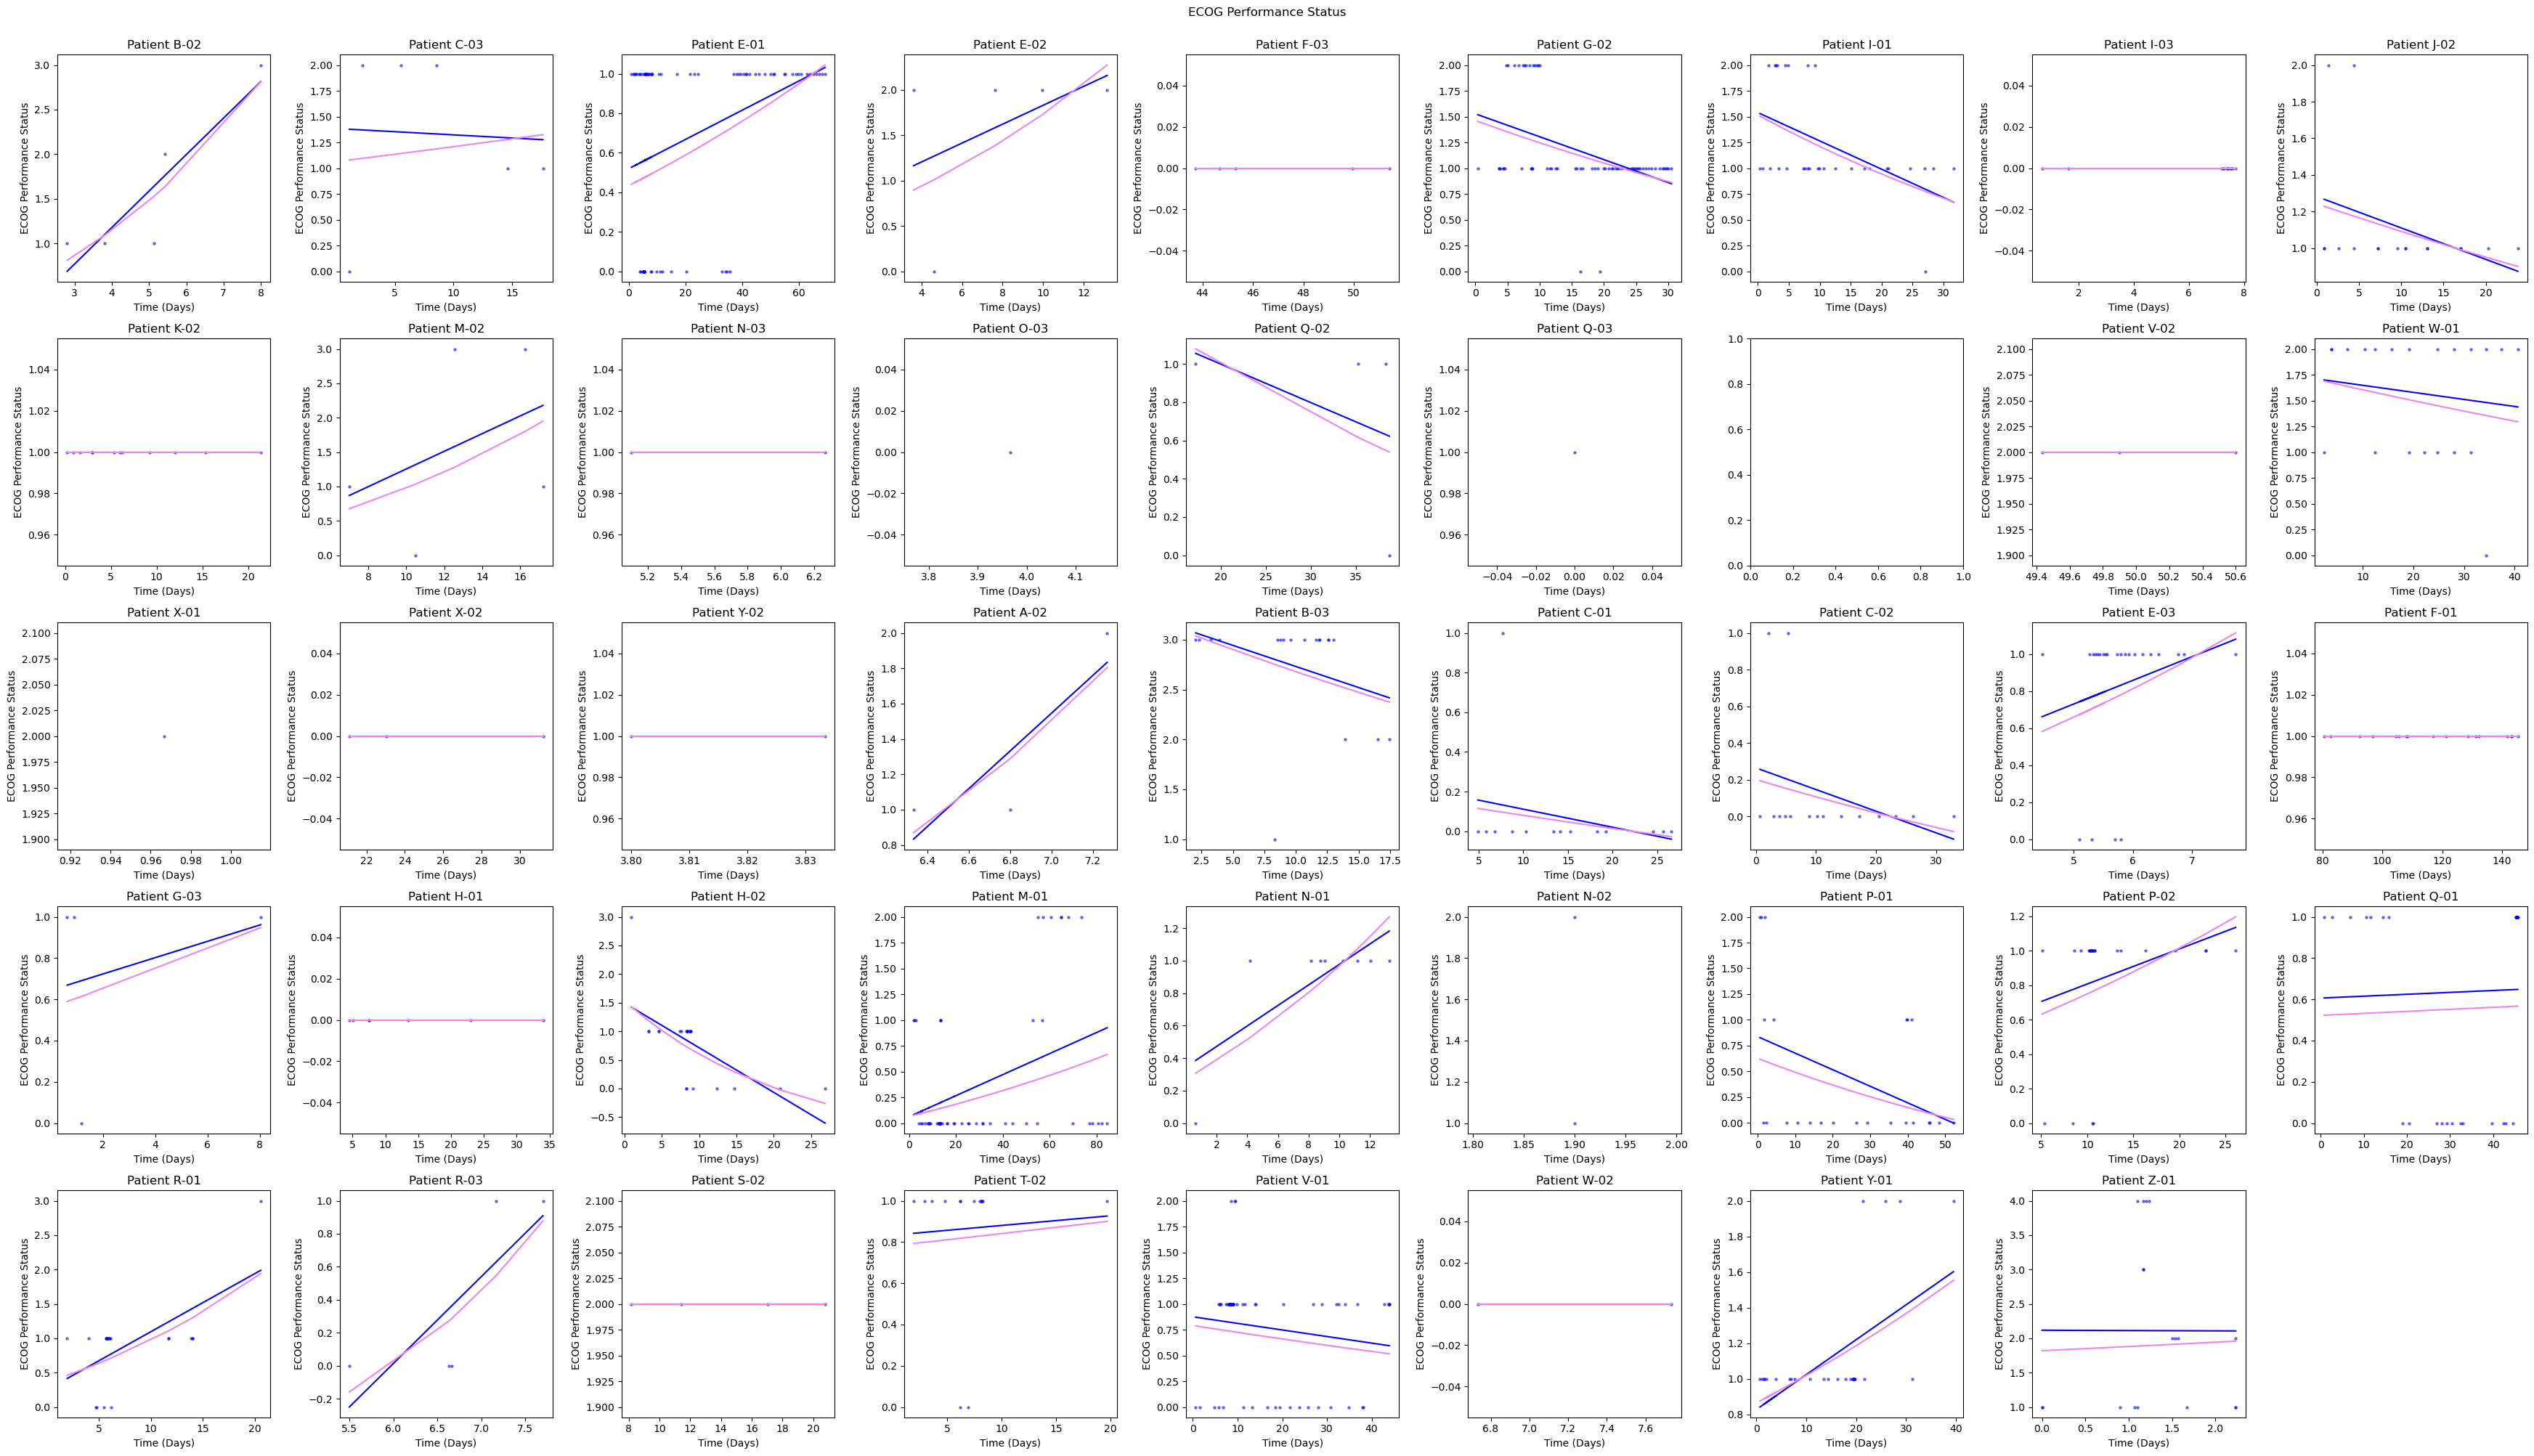

C:\Users\maega\AppData\Local\Temp\ipykernel_9488\2888434675.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  coef = float(regression.coef_)
C:\Users\maega\AppData\Local\Temp\ipykernel_9488\2888434675.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  coef = float(regression.coef_)
C:\Users\maega\AppData\Local\Temp\ipykernel_9488\2888434675.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  coef = float(regression.coef_)
C:\Users\maega\AppData\Local\Temp\ipy

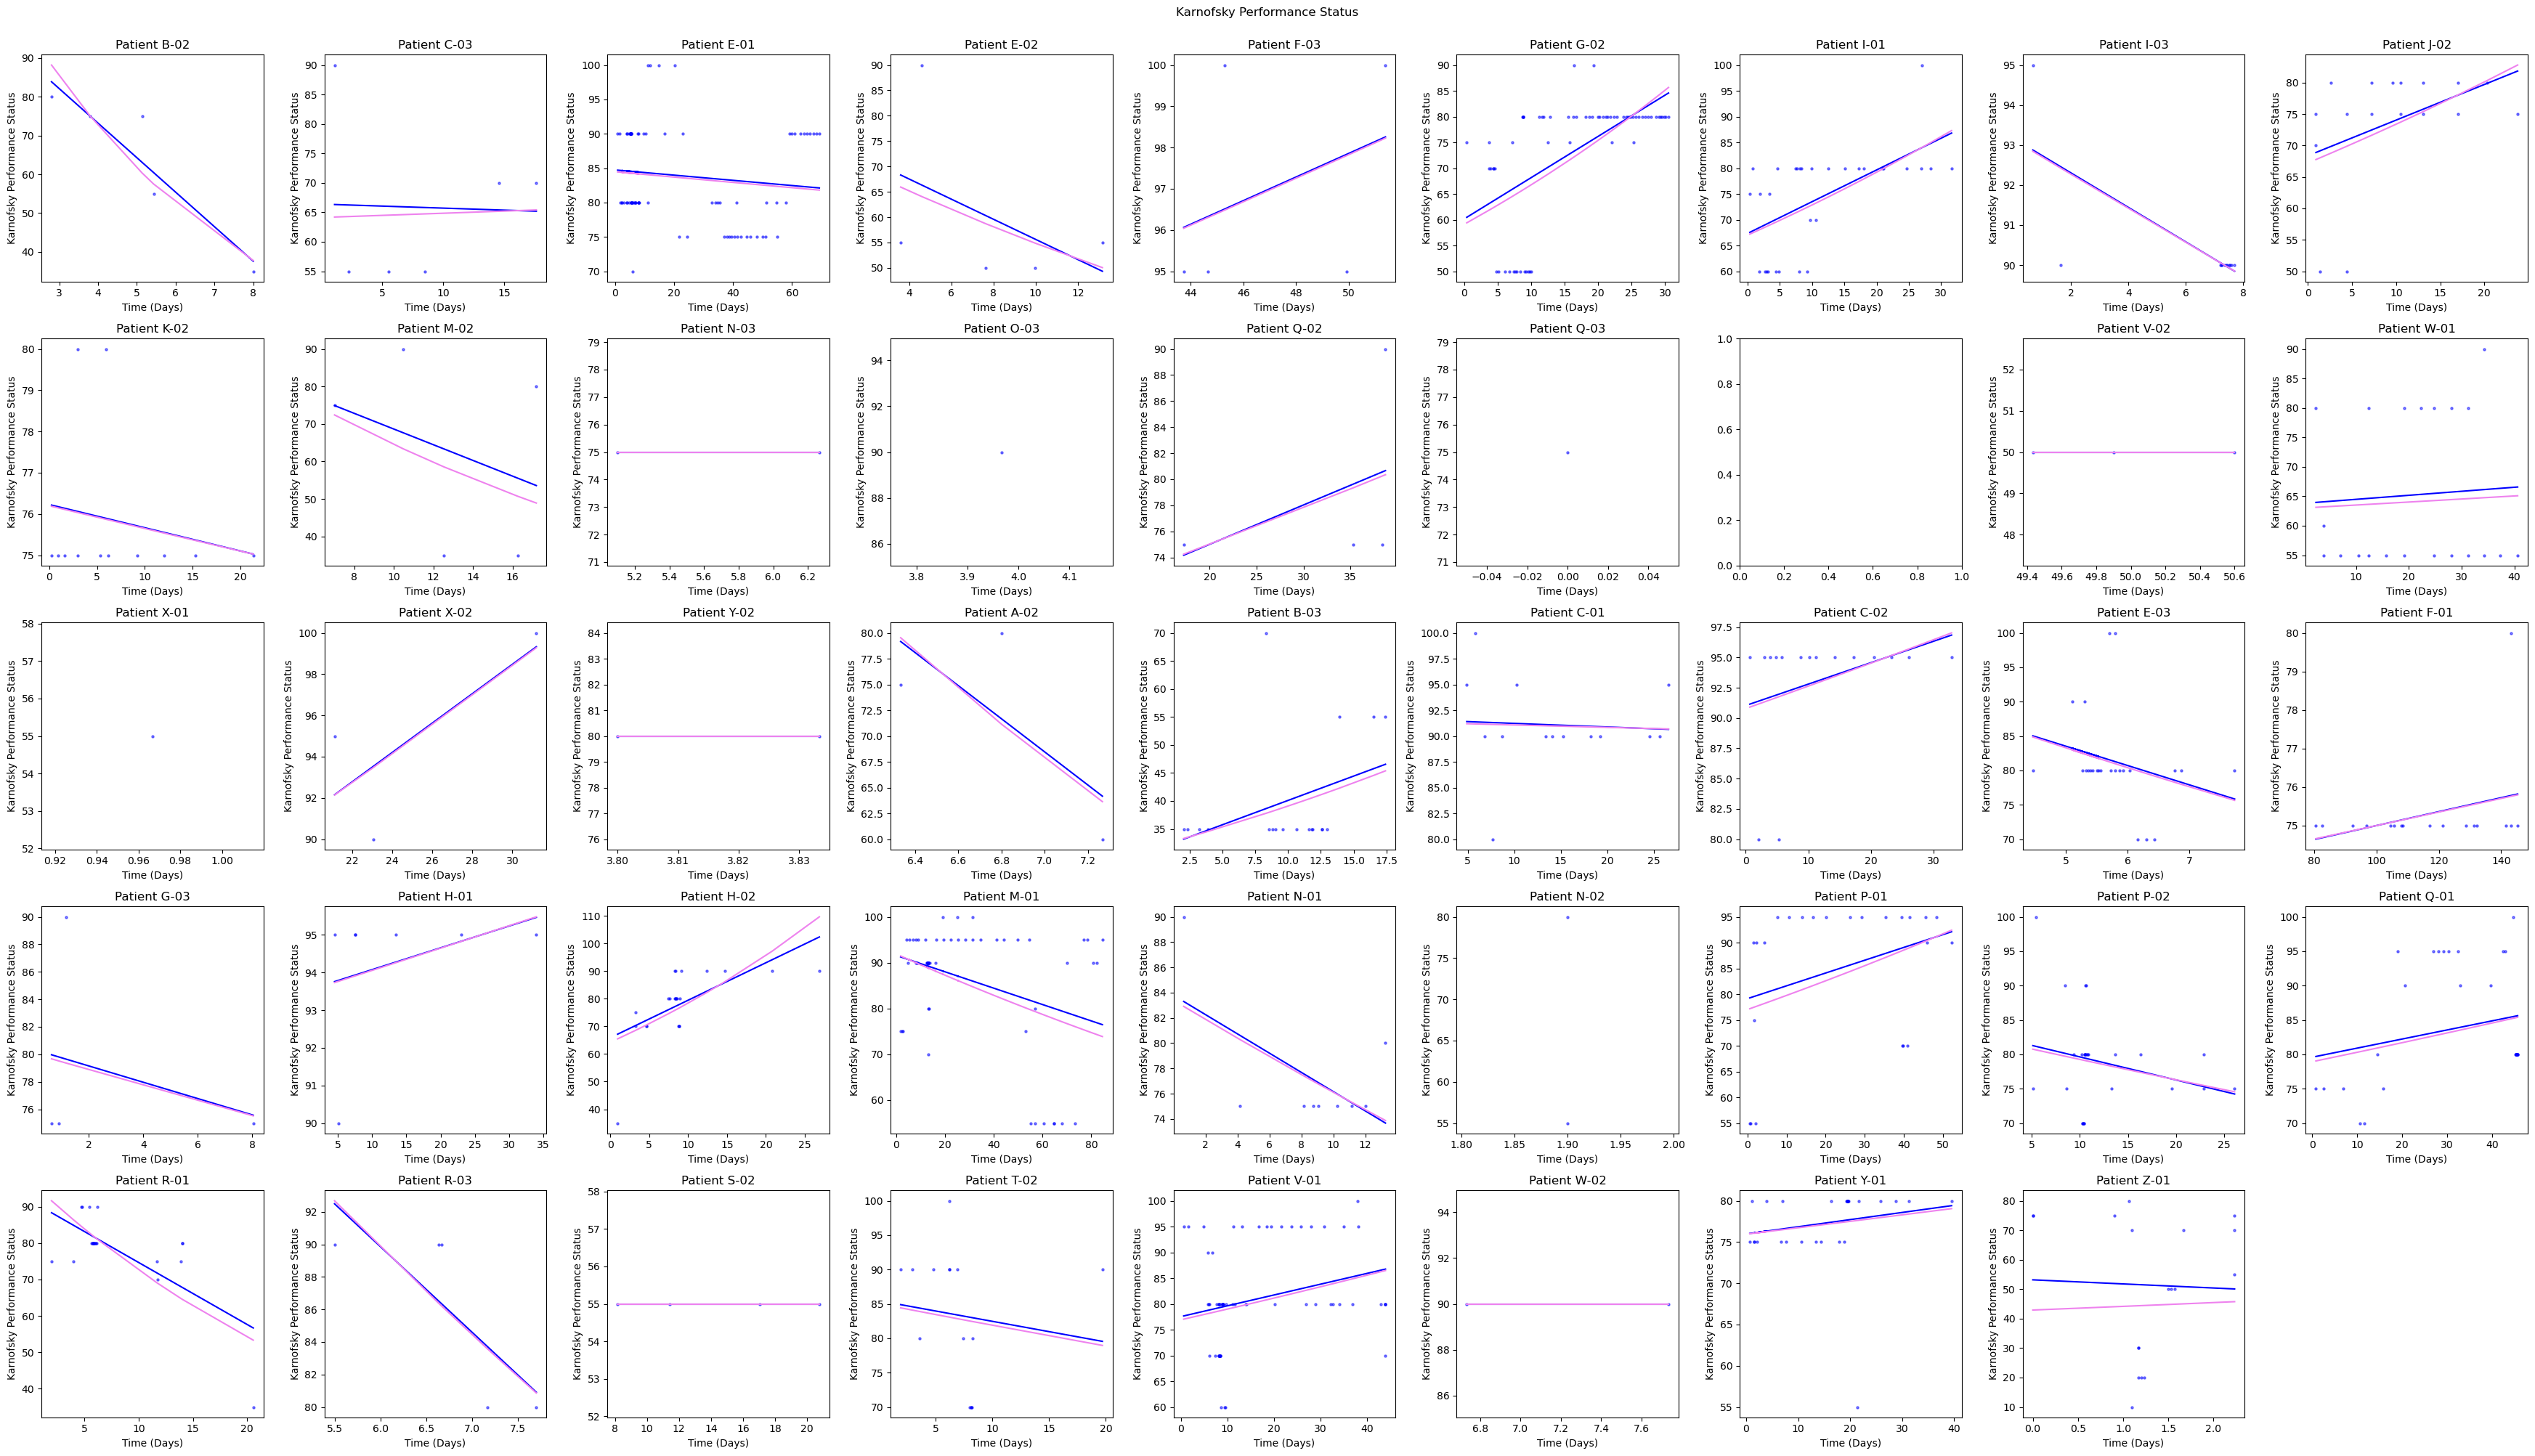

In [100]:
# labsOFInterest = filteredLabs #to plot all of the filtered labs
# noteColumns

# Set up the grid of subplots
num_patients = len(listKnown)
cols = 9  # Number of columns in the grid
rows = (num_patients // cols) + (num_patients % cols > 0)  # Calculate rows needed
for lab in noteColumns:
        fig, axes = plt.subplots(rows, cols, figsize=(35, rows * 4))
        axes = axes.flatten()  # Flatten the axes array for easy indexing

        # Loop through each patient and plot their data
        for i, pt in enumerate(listKnown):
            ax = axes[i]
            ptLabsData = ptDictMDnotesScored[pt]
            #check that patient has data 
            if not isinstance(ptLabsData, bool):
                ptLabsData= ptLabsData[['time from diagnosis to note (months)', lab]]
                
                # Prepare data for linear fit without forcing baseline
                x_values, y_values_shift, datalength, baseline = prepDataForFit_v2(ptLabsData, 'time from diagnosis to note (months)', lab, transform = ["none"], shift = False)

                #scatter plot of the original data
                ax.scatter(x_values, y_values_shift, marker='o', color='blue', s=5, alpha=0.5, label='data')

                # Perform linear fit
                coef, intercept, mse, r2, y_prediction = linear_model_fit_v2(x = x_values, y=  y_values_shift, datalength=datalength, baseline = baseline, forced= False)
                # ax.scatter(x_values, y_values_shift + baseline, marker='o', color='blue', s=5, alpha=0.5, label='data')
                ax.plot(x_values, y_prediction, color='blue', label='linear fit')
                
                # Prepare data for exponential fit without forcing baseline
                x_values, y_values_shift, datalength, baseline = prepDataForFit_v2(ptLabsData, 'time from diagnosis to note (months)', lab, transform = ["ln"], shift=False)
                
                # Perform exponential fit
                coef, intercept, mse, r2, y_prediction = linear_model_fit_v2(x = x_values, y=  y_values_shift, datalength=datalength, baseline = baseline, forced = False)
                ax.plot(x_values, np.exp(y_prediction) - 1, color='violet', label='exp fit')
                
                # # Add vertical line for echo date
                # ax.axvline(x=imagingAndLabDates_df.loc[pt, 'ImagingDate'], color='red', linestyle='--', label='echo date')
                
                # Set title and labels
                ax.set_title(f'Patient {pt}')
                ax.set_xlabel('Time (Days)')
                ax.set_ylabel(lab)
            else:
                 continue

        fig.suptitle(lab, y = 1)
        
        # Remove unused subplots
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        # Adjust layout
        fig.tight_layout()
        
        plt.show()
        # figname = ptfn.outputFiguresPath(fileName_header= "MultiPlot_DataFits_sk_", fileName_mid= lab, fileName_suff="", parent_dir=outputDir, folderName=folderNameOut)
        # fig.savefig(figname)